In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Paths (Update these to your actual folders)
REAL_CT_PATH = "C:/Users/uppal/OneDrive/Desktop/a/images/real"  # Real images folder
FAKE_CT_PATH = "C:/Users/uppal/OneDrive/Desktop/a/images/fake"  # Fake images folder
OUTPUT_DIR = "processed_lung_ct_inceptionv3"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 299  # InceptionV3 expects 299x299 input
CHANNELS = 3    

def load_images_from_folder(folder):
    """Loads and processes images from a given folder."""
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load as is
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 299x299
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
            img = preprocess_input(img)  # Apply InceptionV3 preprocessing
            images.append(img)
    return np.array(images, dtype=np.float32)

# ✅ Load real and fake images
real_images = load_images_from_folder(REAL_CT_PATH)
fake_images = load_images_from_folder(FAKE_CT_PATH)

# ✅ Create labels (0 = real, 1 = fake)
real_labels = np.zeros(len(real_images))
fake_labels = np.ones(len(fake_images))

# ✅ Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# ✅ Train-validation-test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Save preprocessed data
np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "X_val.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "y_val.npy"), y_val)
np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)

# ✅ Print dataset sizes
print(f"✅ Preprocessing complete! Data saved in `{OUTPUT_DIR}`")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training set: {X_train.shape[0]} | Validation set: {X_val.shape[0]} | Testing set: {X_test.shape[0]}")


✅ Preprocessing complete! Data saved in `processed_lung_ct_inceptionv3`
Real images: 900 | Fake images: 900
Training set: 1440 | Validation set: 180 | Testing set: 180


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import os

# ✅ Load preprocessed dataset
DATASET_DIR = "processed_lung_ct_inceptionv3"
X_train = np.load(os.path.join(DATASET_DIR, "X_train.npy"))
X_val = np.load(os.path.join(DATASET_DIR, "X_val.npy"))
y_train = np.load(os.path.join(DATASET_DIR, "y_train.npy"))
y_val = np.load(os.path.join(DATASET_DIR, "y_val.npy"))

# ✅ Load InceptionV3 (Pretrained) as a feature extractor
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model layers

# ✅ Define model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten (better for InceptionV3)
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Real (0) or Fake (1)
])

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_lung_ct_inceptionv3.h5", save_best_only=True, monitor='val_loss')

# ✅ Train model with callbacks
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

print("✅ Model training complete. Best model saved as best_lung_ct_inceptionv3.h5")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 93s 1us/step
Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6069 - loss: 1.2690

90/90 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.6080 - loss: 1.2668 - val_accuracy: 0.8833 - val_loss: 0.8524
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8405 - loss: 0.8089

90/90 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8407 - loss: 0.8088 - val_accuracy: 0.9000 - val_loss: 0.7261
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8765 - loss: 0.7284

90/90 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.8765 - loss: 0.7282 - val_accuracy: 0.9111 - val_loss: 0.6545
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9002 - loss: 0.6679

90/90 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9002 - loss: 0.6679 - val_accuracy: 0.9056 - val_loss: 0.6281
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9162 - loss: 0.6352

90/90 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9164 - loss: 0.6350 - val_accuracy: 0.9167 - val_loss: 0.6035
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9310 - loss: 0.5987

90/90 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.9310 - loss: 0.5987 - val_accuracy: 0.9222 - val_loss: 0.5874
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9352 - loss: 0.5812

90/90 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9351 - loss: 0.5813 - val_accuracy: 0.9333 - val_loss: 0.5817
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9486 - loss: 0.5499

90/90 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9486 - loss: 0.5500 - val_accuracy: 0.9278 - val_loss: 0.5664
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9420 - loss: 0.5637

90/90 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9421 - loss: 0.5636 - val_accuracy: 0.9333 - val_loss: 0.5575
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9588 - loss: 0.5300 - val_accuracy: 0.9222 - val_loss: 0.5637
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9680 - loss: 0.4979

90/90 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9680 - loss: 0.4980 - val_accuracy: 0.9278 - val_loss: 0.5522
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9699 - loss: 0.4856

90/90 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9699 - loss: 0.4856 - val_accuracy: 0.9444 - val_loss: 0.5390
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.9688 - loss: 0.4993 - val_accuracy: 0.9333 - val_loss: 0.5414
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9753 - loss: 0.4765

90/90 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9752 - loss: 0.4765 - val_accuracy: 0.9333 - val_loss: 0.5380
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9658 - loss: 0.4877

90/90 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.9659 - loss: 0.4875 - val_accuracy: 0.9444 - val_loss: 0.5249
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9773 - loss: 0.4526

90/90 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9773 - loss: 0.4526 - val_accuracy: 0.9500 - val_loss: 0.5180
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9861 - loss: 0.4346

90/90 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9861 - loss: 0.4347 - val_accuracy: 0.9444 - val_loss: 0.5138
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9813 - loss: 0.4526

90/90 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.9813 - loss: 0.4525 - val_accuracy: 0.9444 - val_loss: 0.5001
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9835 - loss: 0.4271 - val_accuracy: 0.9444 - val_loss: 0.5014
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9847 - loss: 0.4222

90/90 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9847 - loss: 0.4222 - val_accuracy: 0.9444 - val_loss: 0.4960
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9800 - loss: 0.4288

90/90 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9801 - loss: 0.4287 - val_accuracy: 0.9500 - val_loss: 0.4897
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9844 - loss: 0.4141 - val_accuracy: 0.9500 - val_loss: 0.4900
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9786 - loss: 0.4183

90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.9786 - loss: 0.4183 - val_accuracy: 0.9500 - val_loss: 0.4806
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9868 - loss: 0.3974 - val_accuracy: 0.9556 - val_loss: 0.4873
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.9836 - loss: 0.4014 - val_accuracy: 0.9556 - val_loss: 0.4826
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.9877 - loss: 0.3813 - val_accuracy: 0.9500 - val_loss: 0.4879
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9867 - loss: 0.3768

90/90 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9867 - loss: 0.3768 - val_accuracy: 0.9500 - val_loss: 0.4635
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9871 - loss: 0.3731 - val_accuracy: 0.9500 - val_loss: 0.4790
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.9892 - loss: 0.3611 - val_accuracy: 0.9444 - val_loss: 0.4847
Epoch 30/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9858 - loss: 0.3751 - val_accuracy: 0.9500 - val_loss: 0.4684
✅ Model training complete. Best model saved as best_lung_ct_inceptionv3.h5


In [3]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_lung_ct_inceptionv3.h5")

# Print model summary to confirm it's loaded
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,335,779 (85.20 MB)

 Trainable params: 528,897 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

 Optimizer params: 2 (12.00 B)

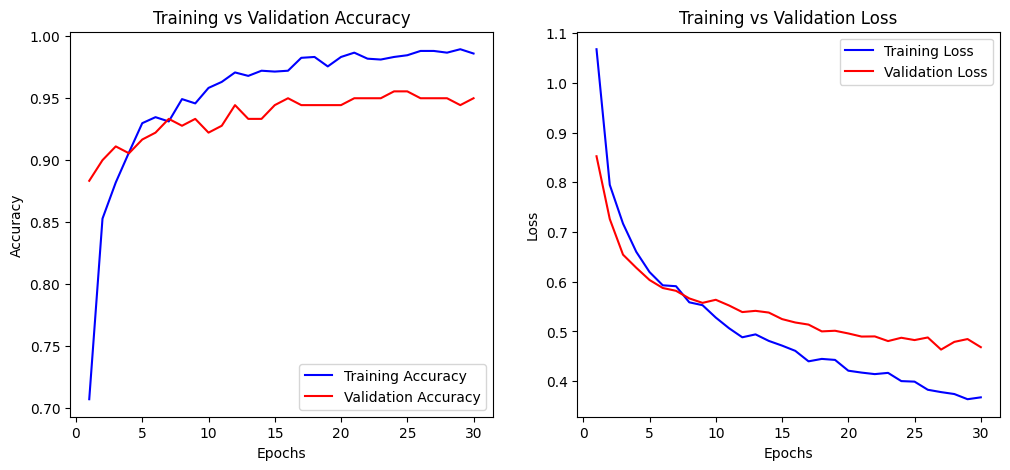

In [4]:
import matplotlib.pyplot as plt

# ✅ Plot Training Performance
def plot_training(history):
    """Plots training accuracy & loss."""
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.show()

# ✅ Show Training Plots
plot_training(history)


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step
Classification Report:
               precision    recall  f1-score   support

        Real       0.95      0.97      0.96        90
        Fake       0.97      0.94      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



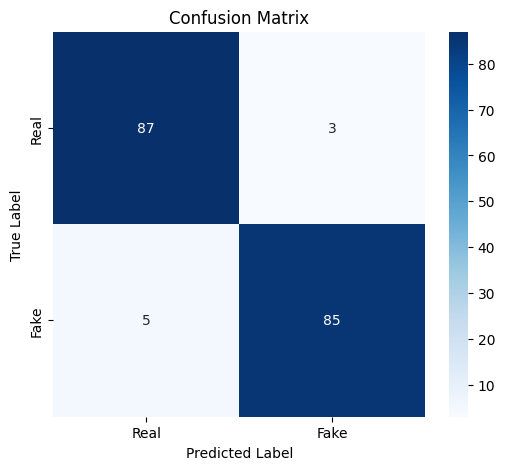

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [11]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os

# ✅ Load the trained GoogLeNet/Inception model
MODEL_PATH = "best_lung_ct_inceptionv3.h5"  # Update this to your GoogLeNet model path
model = load_model(MODEL_PATH, compile=False)

# InceptionV3 expects 299x299x3 input
IMG_SIZE = 299  
CHANNELS = 3    

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 299x299 (GoogLeNet/InceptionV3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = preprocess_input(img)  # Apply InceptionV3 preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0][0]  # Get prediction (single value)
        
        if prediction < 0.5:
            result = "✅ Real CT Scan (Class 0)"
        else:
            result = "❌ Fake CT Scan (Class 1)"
        
        print(f"Prediction: {prediction:.4f} --> {result}")
    except Exception as e:
        print(f"Error: {e}")

# ✅ Example usage
IMAGE_PATH = "C:/Users/uppal/OneDrive/Desktop/DL/f3.png"  # Change this to your test image path
predict_image(IMAGE_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: 0.4237 --> ✅ Real CT Scan (Class 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r1.png: 0.0025 --> ✅ Real CT Scan (Class 0)


C:\Users\uppal\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


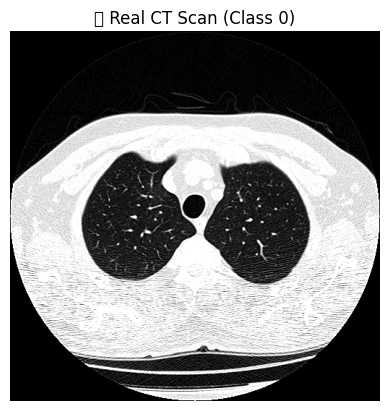

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r2.png: 0.0000 --> ✅ Real CT Scan (Class 0)


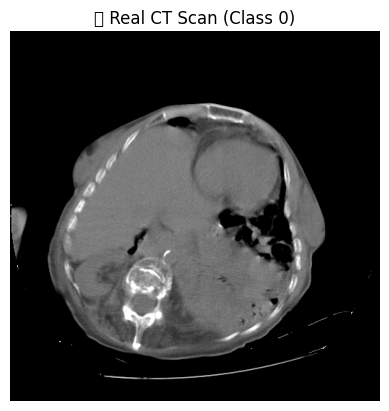

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Prediction for C:/Users/uppal/OneDrive/Desktop/DL/r3.png: 0.0026 --> ✅ Real CT Scan (Class 0)


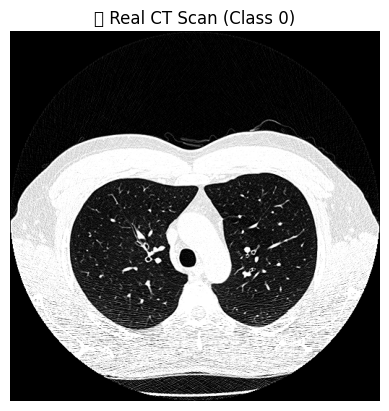

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
import matplotlib.pyplot as plt  # For displaying images

# ✅ Load the trained InceptionV3 model
MODEL_PATH = "best_lung_ct_inceptionv3.h5"  # Make sure this path is correct
model = load_model(MODEL_PATH, compile=False)

# InceptionV3 expects input shape: 299x299x3
IMG_SIZE = 299
CHANNELS = 3

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = preprocess_input(img)  # Apply InceptionV3 preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction and visualize the result
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)
        prediction = model.predict(img)[0][0]  # Binary classification output
        
        if prediction < 0.5:
            result = "✅ Real CT Scan (Class 0)"
        else:
            result = "❌ Fake CT Scan (Class 1)"
        
        print(f"Prediction for {image_path}: {prediction:.4f} --> {result}")
        
        # Show the image with matplotlib
        img_to_show = cv2.imread(image_path)
        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_show)
        plt.axis('off')
        plt.title(result)
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# ✅ Example usage (update the paths as needed)
IMAGE_PATHS = [
    "C:/Users/uppal/OneDrive/Desktop/DL/r1.png",
    "C:/Users/uppal/OneDrive/Desktop/DL/r2.png",
    "C:/Users/uppal/OneDrive/Desktop/DL/r3.png"
]

for path in IMAGE_PATHS:
    predict_image(path)


57/57 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step


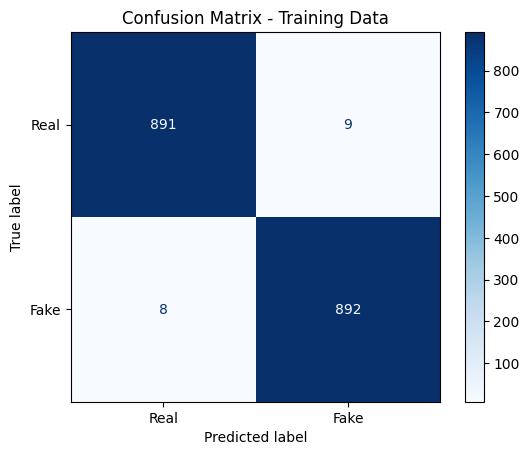

In [15]:
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Set paths and model
TRAIN_DIR = "C:/Users/uppal/OneDrive/Desktop/DL/images"  # contains 'real' and 'fake' folders
MODEL_PATH = "best_lung_ct_inceptionv3.h5"
IMG_SIZE = 299
model = load_model(MODEL_PATH, compile=False)

# ✅ Load training images and labels
X_train = []
y_train = []

for label, class_name in enumerate(["real", "fake"]):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img)
            X_train.append(img)
            y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# ✅ Predict and compute confusion matrix
y_pred_probs = model.predict(X_train)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Training Data")
plt.show()
